Ziel: Testen eines einfachen neuronalen Netzes zur Vorhersage der AQI_Max-Werte  
Features: die auch vorher verwendeten Features aus Predictor + CO Schadstoff-Werte + die wichtigsten Features vom Vortrag


In [23]:
#Import 
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics


In [2]:
#Laden der Df
pollution = pd.read_hdf("Pollution_Data/pollutant_data.h5")
predictor = pd.read_hdf("Predictor_Data/all_numeric.h5")

In [3]:
# Imputer
predictor= pd.DataFrame(IterativeImputer(verbose=1,max_iter=30).fit_transform(predictor),columns=predictor.columns,index=predictor.index)
all_data=predictor.join(pollution[["mean_co","max_value_co","aqi_max"]])
all_data.dropna(inplace=True)
all_data.info()

[IterativeImputer] Completing matrix with shape (4017, 28)
[IterativeImputer] Change: 59.73678381794546, scaled tolerance: 1.317 
[IterativeImputer] Change: 47.73176195567502, scaled tolerance: 1.317 
[IterativeImputer] Change: 37.95243328555524, scaled tolerance: 1.317 
[IterativeImputer] Change: 30.81696948669024, scaled tolerance: 1.317 
[IterativeImputer] Change: 26.359113595508713, scaled tolerance: 1.317 
[IterativeImputer] Change: 22.578683804888385, scaled tolerance: 1.317 
[IterativeImputer] Change: 19.27970975763293, scaled tolerance: 1.317 
[IterativeImputer] Change: 16.372814289929043, scaled tolerance: 1.317 
[IterativeImputer] Change: 13.829716730189459, scaled tolerance: 1.317 
[IterativeImputer] Change: 11.626324748483903, scaled tolerance: 1.317 
[IterativeImputer] Change: 9.735412277065546, scaled tolerance: 1.317 
[IterativeImputer] Change: 8.123406958029445, scaled tolerance: 1.317 
[IterativeImputer] Change: 6.75585642118407, scaled tolerance: 1.317 
[IterativeImpu

In [55]:
all_data["aqi_max"].value_counts()

Fair              1987
Moderate          1363
Poor               504
Very Poor            7
Extremely Poor       0
Name: aqi_max, dtype: int64

In [58]:
'entfernen von very poor'

all_data=all_data[all_data["aqi_max"] != "Very Poor"]
all_data["aqi_max"].value_counts()

Fair              1987
Moderate          1363
Poor               504
Very Poor            0
Extremely Poor       0
Name: aqi_max, dtype: int64

In [67]:
aqi_labels={0:"Fair",1:"Moderate",2:"Poor"}
X = all_data.drop("aqi_max",axis=1)
y = all_data["aqi_max"].cat.codes
X_train,X_test,y_train,y_test= model_selection.train_test_split(X,y)

### Quellen: 
[Sequential Model](https://www.tensorflow.org/guide/keras/sequential_model#setup)
[Example with Classification](https://www.tensorflow.org/tutorials/keras/classification)
[API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)

- 'SparseCategoricalCrossentropy' scheint für diesen Fall hier gut geeignet da mehrere categorical labels unterstützt werden 
- logits: the vector of raw (non-normalized) predictions that a classification model generates, which is ordinarily then passed to a normalization function. If the model is solving a multi-class classification problem, logits typically become an input to the softmax function. The softmax function then generates a vector of (normalized) probabilities with one value for each possible class. [aus Stackoverflow](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow). Daher also genau der Fall der hier auftritt
- He initializer der Gewichte [analyticsvidhya](https://www.analyticsvidhya.com/blog/2021/09/a-comprehensive-guide-on-neural-networks-performance-optimization/)

In [77]:
#create a simple neural Network
initializer = tf.keras.initializers.HeNormal(seed=1)
model = keras.Sequential()
model.add(keras.Input(shape=(30,)))
for i in range(0,12):
    model.add(layers.Dense(65,activation="relu",name=f"hidden_layer_{i}",kernel_initializer=initializer))
model.add(layers.Dense(3,activation="softmax",name="output_layer"))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_0 (Dense)      (None, 65)                2015      
                                                                 
 hidden_layer_1 (Dense)      (None, 65)                4290      
                                                                 
 hidden_layer_2 (Dense)      (None, 65)                4290      
                                                                 
 hidden_layer_3 (Dense)      (None, 65)                4290      
                                                                 
 hidden_layer_4 (Dense)      (None, 65)                4290      
                                                                 
 hidden_layer_5 (Dense)      (None, 65)                4290      
                                                                 
 hidden_layer_6 (Dense)      (None, 65)              

In [78]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # this loss function fits for 2 or more categorial labels, 
              metrics=['accuracy'])



In [79]:
model.fit(X_train, y_train, epochs=3600,use_multiprocessing=True)

Epoch 1/5
91/91 [==============================] - 8s 52ms/step - loss: 17.9666 - accuracy: 0.4401
Epoch 2/5
91/91 [==============================] - 4s 49ms/step - loss: 2.3126 - accuracy: 0.4723
Epoch 3/5
91/91 [==============================] - 6s 66ms/step - loss: 2.1527 - accuracy: 0.4564
Epoch 4/5
91/91 [==============================] - 6s 65ms/step - loss: 1.6577 - accuracy: 0.4841
Epoch 5/5
91/91 [==============================] - 6s 62ms/step - loss: 1.1367 - accuracy: 0.5187


In [71]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

31/31 - 2s - loss: 0.9167 - accuracy: 0.5270 - 2s/epoch - 57ms/step


In [81]:
name="model"
model.save(f"keras_models/{name}")

INFO:tensorflow:Assets written to: keras_models/model/assets


31/31 [==============================] - 1s 33ms/step
Test Score of the Models
score of the model: 0.52697
balanced score of the model: 0.37628
f1 score of the model: 0.45284


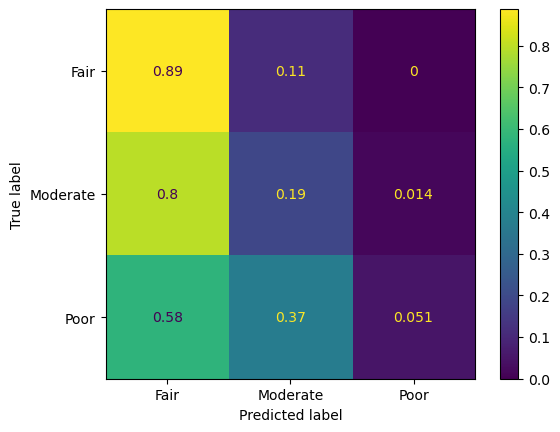

In [72]:
y_predict=model.predict(X_test).argmax(axis=1)
y_predict_cat=pd.Series(y_predict).map(aqi_labels)
y_test_cat=pd.Series(y_test).map(aqi_labels)

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=metrics.confusion_matrix(y_true=y_test_cat,y_pred=y_predict_cat,labels=list(aqi_labels.values()),normalize="true")
disp = metrics.ConfusionMatrixDisplay(cm,display_labels=list(aqi_labels.values()))
disp.plot()

In [66]:
y_predict=model.predict(X_test).argmax(axis=1)
pd.Series(y_predict).value_counts()

31/31 [==============================] - 1s 24ms/step


1    525
0    414
2     25
dtype: int64

In [43]:
list(aqi_labels.values())


['Good', 'Fair', 'Moderate', 'Poor', 'Very Poor']